<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task10/Classification_model_MLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2500 non-null   float64
 1   volatile acidity      2500 non-null   float64
 2   citric acid           2500 non-null   float64
 3   residual sugar        2500 non-null   float64
 4   chlorides             2500 non-null   float64
 5   free sulfur dioxide   2500 non-null   float64
 6   total sulfur dioxide  2500 non-null   float64
 7   density               2500 non-null   float64
 8   pH                    2500 non-null   float64
 9   sulphates             2500 non-null   float64
 10  alcohol               2500 non-null   float64
 11  quality               2500 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 234.5 KB
None

Summary Statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    2500.0000

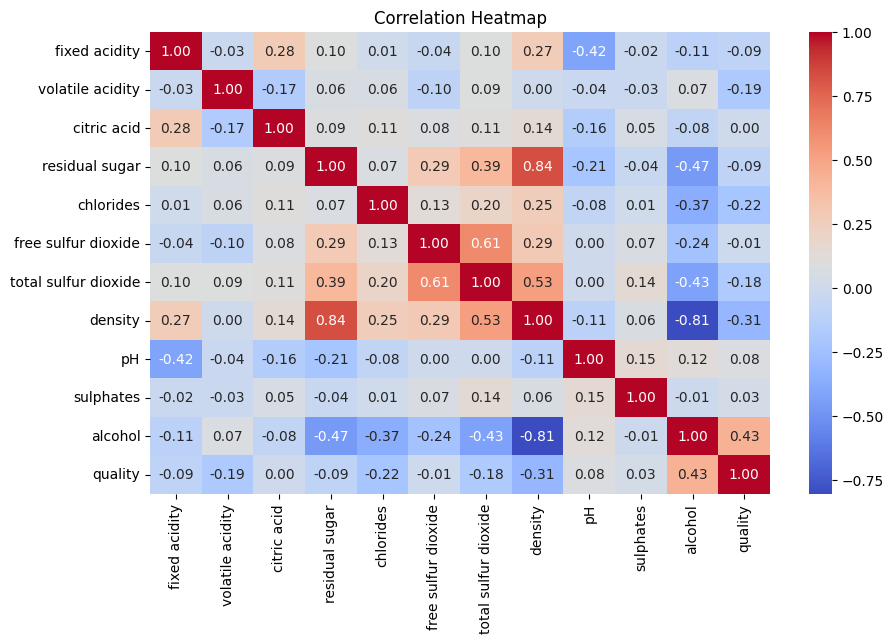

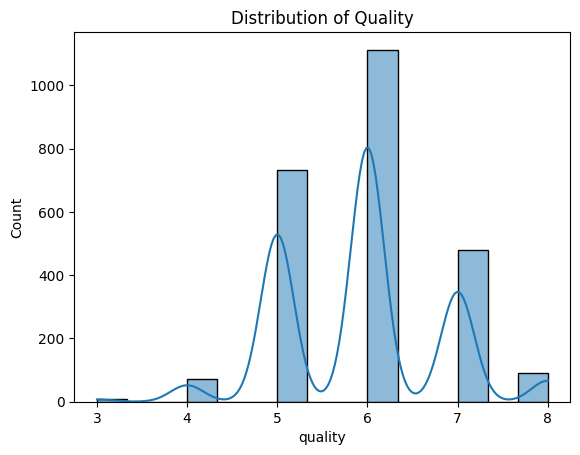

Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=10, batch_size=16
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=10, batch_size=32
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=10, batch_size=64
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=10, batch_size=128
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=10, batch_size=256
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=1, batch_size=16
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=1, batch_size=32
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=1, batch_size=64
Epoch 1/1
Evaluating config: hidden_layers=[4], activation_fn=linear, epochs=1, learning_rate=1, batch_size=128
Epo

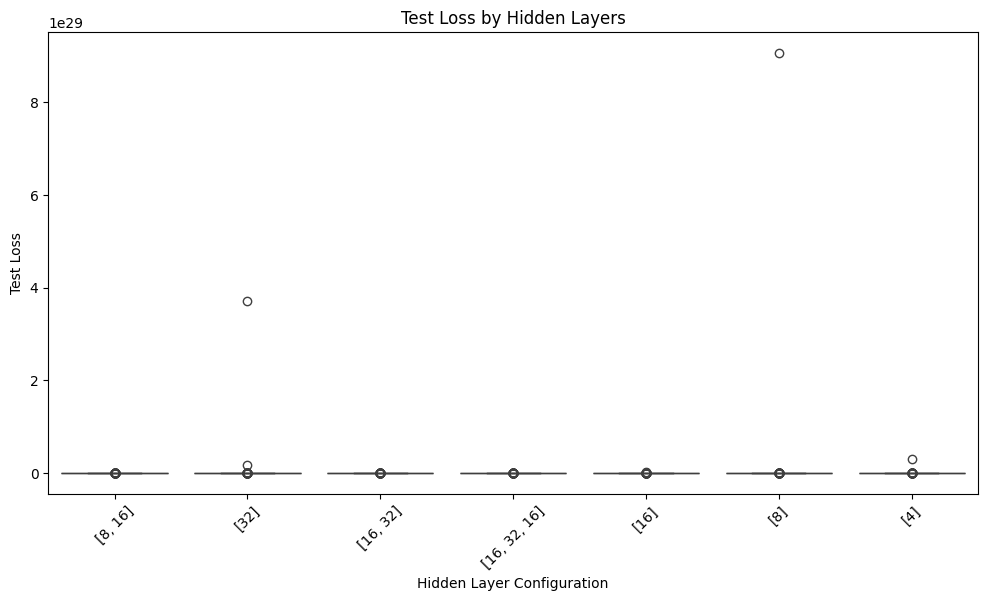

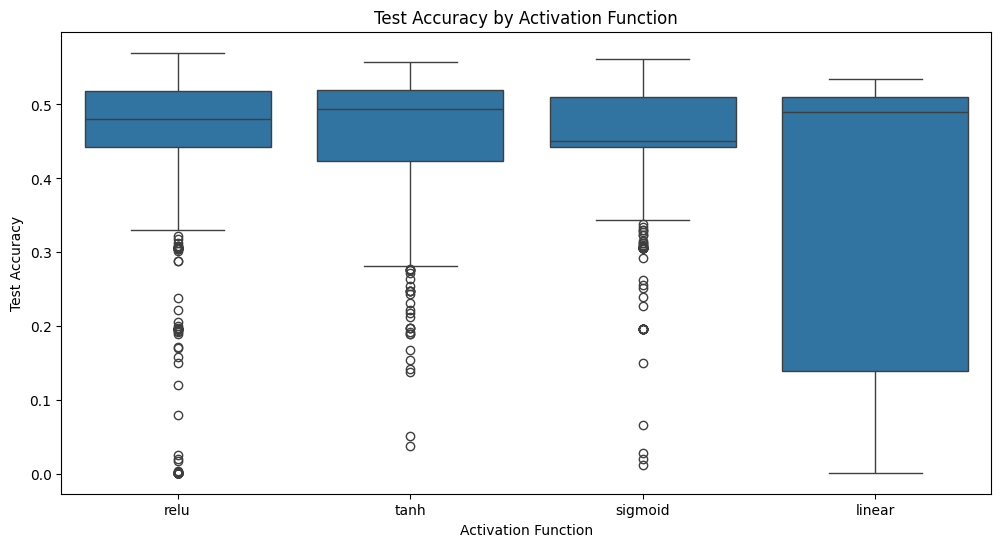

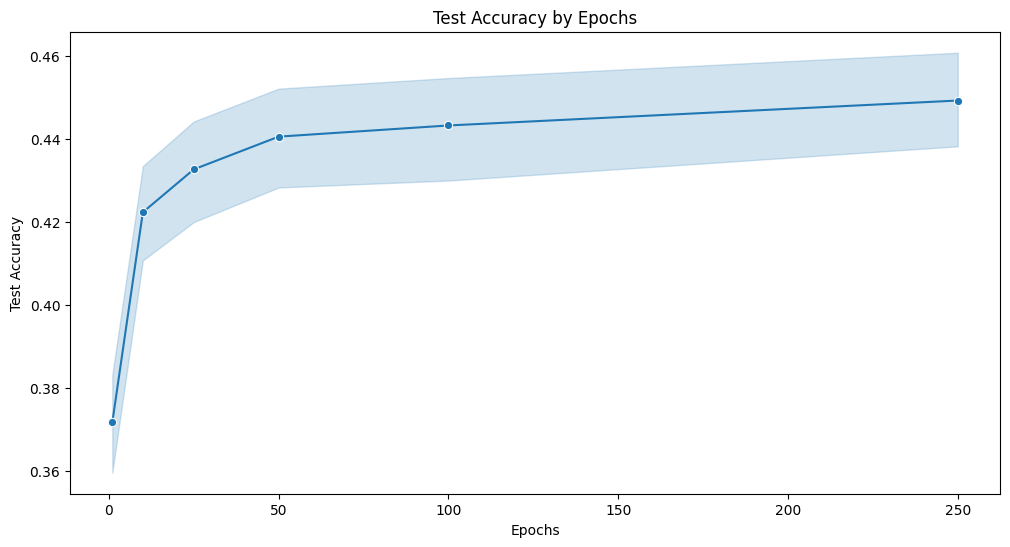

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data = pd.read_csv("C:/Users/mhafi/Downloads/Documents/winequality-white.csv", sep=';')

# Handle missing values
data = data.dropna()  # Remove rows with NaN values

# Limit dataset to 2500 samples
data = data.sample(n=2500, random_state=42).reset_index(drop=True)

# Exploratory Data Analysis (EDA)
def eda(data):
    print("Data Info:")
    print(data.info())
    print("\nSummary Statistics:")
    print(data.describe())
    print("\nMissing Values:")
    print(data.isnull().sum())

    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    sns.histplot(data['quality'], kde=True, bins=15)
    plt.title("Distribution of Quality")
    plt.show()

eda(data)

# Preprocess data
X = data.drop(columns=['quality'])
y = data['quality']

# Convert target to categorical (classification)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Transform target to integers (0, 1, ...)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # For classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define MLP Model class
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, num_classes):
        super(MLPClassifier, self).__init__()
        layers = []
        for i, hidden_units in enumerate(hidden_layers):
            layers.append(nn.Linear(input_size if i == 0 else hidden_layers[i - 1], hidden_units))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'linear':
                pass  # No activation
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Hyperparameter grid
hidden_layer_configs = [[4], [8], [16], [32], [8, 16], [16, 32], [16, 32, 16]]
activations = ['linear', 'sigmoid', 'relu', 'tanh']
epochs_list = [1, 10, 25, 50, 100, 250]
learning_rates = [10, 1, 0.1, 0.01]
batch_sizes = [16, 32, 64, 128, 256]

# Training function
def train_model(model, train_loader, test_loader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")  # Progress indicator
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor).item()
        test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.argmax(dim=1).numpy())
    return test_loss, test_accuracy

# Evaluate models
results = []

num_classes = len(np.unique(y))

for hidden_layers in hidden_layer_configs:
    for activation_fn in activations:
        for epochs in epochs_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    print(f"Evaluating config: hidden_layers={hidden_layers}, activation_fn={activation_fn}, epochs={epochs}, learning_rate={lr}, batch_size={batch_size}")  # Progress indicator
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    model = MLPClassifier(input_size=X.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn, num_classes=num_classes)
                    test_loss, test_accuracy = train_model(model, train_loader, test_loader, epochs, lr)

                    results.append({
                        'hidden_layers': hidden_layers,
                        'activation_fn': activation_fn,
                        'epochs': epochs,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'test_loss': test_loss,
                        'test_accuracy': test_accuracy
                    })

# Save results to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='test_loss', inplace=True)

print("Best Configurations:")
print(results_df.head())

# Save results to CSV
results_df.to_csv("mlp_classification_results.csv", index=False)

# Visualization of Results
plt.figure(figsize=(12, 6))
plt.title("Test Loss by Hidden Layers")
sns.boxplot(x=results_df['hidden_layers'].astype(str), y=results_df['test_loss'])
plt.xticks(rotation=45)
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Test Loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Test Accuracy by Activation Function")
sns.boxplot(x=results_df['activation_fn'], y=results_df['test_accuracy'])
plt.xlabel("Activation Function")
plt.ylabel("Test Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Test Accuracy by Epochs")
sns.lineplot(x=results_df['epochs'], y=results_df['test_accuracy'], marker='o')
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()
